# 2020-06-04 Testing and revising nuclear segmentation code

__Goal__: Test nuclear segmentation on multiple zelda and bicoid stacks, assess success, determine causes of failure, attempt to fix. Begin with the three zelda stacks, then move on to Bicoid.

In [1]:
# Import public packages.
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi 
from importlib import reload
%matplotlib inline

# Import my packages.
import sys
sys.path.append('/Users/MStadler/Bioinformatics/Projects/Zelda/Quarantine_analysis/bin')
from imagep import (read_tiff_folder, read_tiff_lattice, viewer, viewer, 
                    segment_embryo, labelmask_apply_morphology, zstack_normalize_mean,
                   peak_local_max_nD, gradient_nD, labelmask_filter_objsize, filter_labelmask,
                   object_circularity, stack_bgsub, segment_nuclei3D_5, segment_nuclei4D,
                    lattice_segment_nuclei_5, dog_filter, imfill, segMS2_3dstack, dog_filter, qax)
import imagep as imp
import fitting as fit

* 20171207_Zldeve_em1_mv1
* 20171207_Zldeve_em1_mv2
* 20171207_Zldeve_em5_mv2

## Zelda

### 20171207_Zldeve_em5_mv2

In [2]:
stack = read_tiff_lattice(
    '/Users/MStadler/Bioinformatics/Projects/Zelda/Quarantine_analysis/data/20171207_Zldeve_em5_mv2/', span=(0,9))
bgsub = stack_bgsub(stack)

/Users/MStadler/opt/anaconda3/lib/python3.7/site-packages/skimage/external/tifffile/tifffile.py:2135: UserWarning: tags are not ordered by code
  warnings.warn("tags are not ordered by code")


/Users/MStadler/Bioinformatics/Projects/Zelda/Quarantine_analysis/bin/imagep.py:351: RuntimeWarning: invalid value encountered in sqrt
  gradient = np.sqrt(sumsq)
/Users/MStadler/Bioinformatics/Projects/Zelda/Quarantine_analysis/bin/imagep.py:810: RuntimeWarning: divide by zero encountered in double_scalars
  circularity = 4 * np.pi * area / (perimeter ** 2)


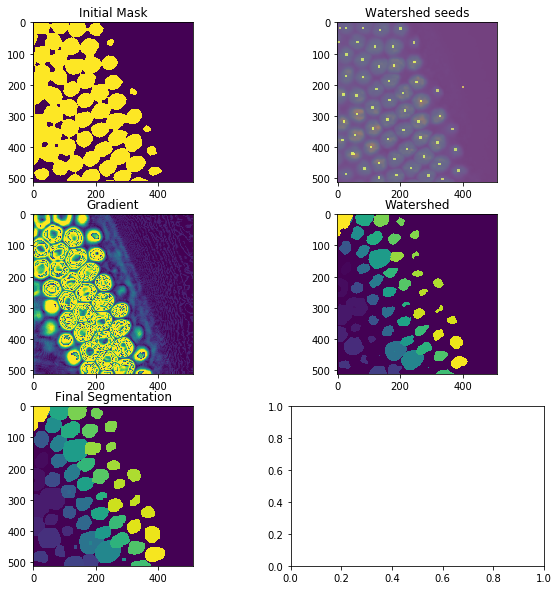

In [3]:
mask = segment_nuclei3D_5(bgsub[1,0], seed_window=(70,50,50), circularity_min=0.1, size_max=5e5, size_min=0, 
                          erosion_length=5, dilation_length=10, display=True)

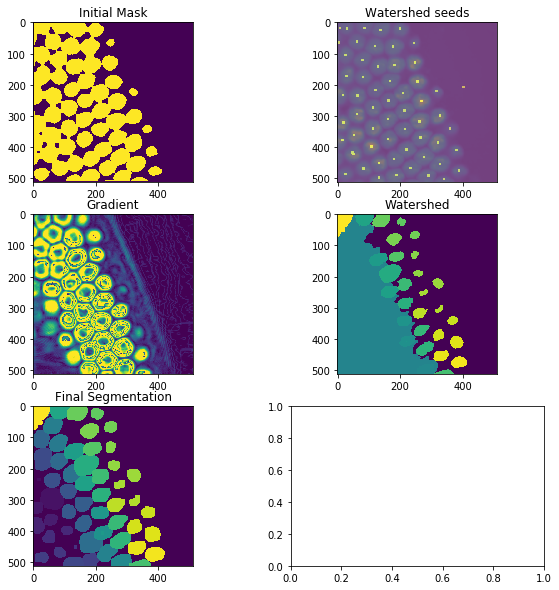

In [4]:
mask1 = segment_nuclei3D_5(bgsub[1,1], seed_window=(70,50,50), circularity_min=0.1, size_max=5e5, size_min=0,
                          erosion_length=5, dilation_length=10, display=True)

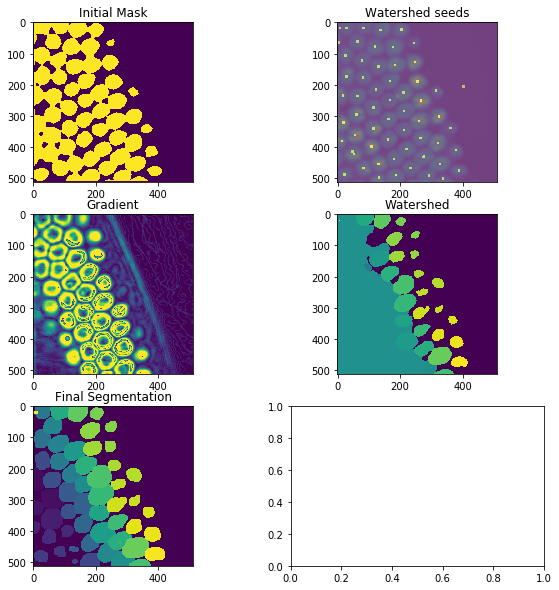

In [5]:
mask2 = segment_nuclei3D_5(bgsub[1,2], seed_window=(70,50,50), circularity_min=0.1, size_max=5e5, size_min=0,
                          erosion_length=5, dilation_length=10, display=True)

In [ ]:
mask3 = segment_nuclei3D_5(bgsub[1,3], seed_window=(70,50,50), circularity_min=0.1, size_max=5e5, size_min=0,
                          erosion_length=5, dilation_length=10, display=True)

In [ ]:
mask4d = lattice_segment_nuclei_5(bgsub[:,4:], seed_window=(70,50,50), circularity_min=0.1, size_max=5e5, size_min=0,erosion_length=5, dilation_length=10)
#viewer(mask4d, 'tzxy')

In [ ]:
viewer(mask4d, 'tzxy')

In [ ]:
mask9 = segment_nuclei3D_5(bgsub[1,9], seed_window=(70,50,50), sigma_dog_big=40, circularity_min=0.1, size_max=5e5, size_min=0,
                          erosion_length=5, dilation_length=10, display=True)

In [ ]:
mask4d = lattice_segment_nuclei_5(bgsub[:,4:], seed_window=(70,50,50), sigma_dog_big=40, circularity_min=0.1, size_max=5e5, size_min=0,erosion_length=5, dilation_length=10)


In [ ]:
viewer(mask4d,'tzxy')

In [ ]:
mask4d2 = lattice_segment_nuclei_5(bgsub[:,0:4], seed_window=(70,50,50), sigma_dog_big=40, circularity_min=0.1, size_max=5e5, size_min=0,erosion_length=5, dilation_length=10)


In [ ]:
viewer(mask4d2, 'tzxy')

So it turns out the 'dropout' in later frames was because the signal actually bleached way down. So not a huge concern--decent nuclear signal will get segmented. That being said, by tweaking the DoG parameters (big=40, small stays at 10) was helpful and almost rescued it through the final frame. Let's see how those DoG settings work for other movies.

## 20171207_Zldeve_em1_mv1

In [ ]:
stack = read_tiff_lattice(
    '/Users/MStadler/Bioinformatics/Projects/Zelda/Quarantine_analysis/data/20171207_Zldeve_em1_mv1/', span=(35,40))
bgsub = stack_bgsub(stack)
#mask4d = lattice_segment_nuclei_5(bgsub[:,4:], seed_window=(70,50,50), circularity_min=0.1, size_max=1e6, size_min=0,erosion_length=5, dilation_length=10)

In [ ]:
mask = segment_nuclei3D_5(bgsub[1,0], seed_window=(70,50,50), circularity_min=0.1, size_max=1e6, size_min=1e4,erosion_length=5, dilation_length=10, display=True)

In [ ]:
def overlay(im,mask):
    plt.imshow(im.max(axis=0), alpha=0.5)
    plt.imshow(mask.max(axis=0), alpha=0.3, cmap="Reds")
        
overlay(stack[1,0], mask)
#viewer(mask,'zxy')

This looks spectacular. Ideal segmentation. All I adjusted was the minimum size to get rid of those little non-nuclear blobs. Trying 4D segmentation:

In [ ]:
mask4d = lattice_segment_nuclei_5(bgsub, seed_window=(70,50,50), circularity_min=0.1, size_max=1e6, size_min=1e4,erosion_length=5, dilation_length=10, display=True)

In [ ]:
viewer([stack[1],mask4d*255],'tzxy')

Looks mostly great. In frame 5 I lost a little bit of the nucleus at ~300,300, not entirely clear why. The gradient still looks fine so it's hard to say why it lost a chunk. It is notable that it picked up an extra watershed seed near that nucleus in that frame. Maybe I'll try tweaking the spacing parameter:

In [ ]:
mask4d = lattice_segment_nuclei_5(bgsub, seed_window=(30,70,70), circularity_min=0.1, size_max=1e6, size_min=1e4,erosion_length=5, dilation_length=10, display=True)

In [ ]:
viewer([mask4d*255, stack[1]], 'tzxy')

That didnt do anything, though it got rid of the additional seed. Really curious. Gonna look under the hood at the gradient which seems like the only possible source of the problem.

In [ ]:
reload(imp)
mask, grad = imp.segment_nuclei3D_5(bgsub[1,0], seed_window=(70,50,50), sigma_dog_big=40, circularity_min=0.1, size_max=1e6, size_min=1e4,erosion_length=5, dilation_length=10, display=True)

In [ ]:
mask2, grad2 = imp.segment_nuclei3D_5(bgsub[1,5], seed_window=(70,100,100), sigma_dog_big=40, circularity_min=0.1, size_max=1e6, size_min=1e4,erosion_length=5, dilation_length=10, display=True)

In [ ]:
viewer(grad, 'zxy')

In [ ]:
viewer(grad2, 'zxy')

Hmm the gradients don't seem particularly different. It's gotta be the seeds. I think the second seed is actually on the gradient border in frame 5. I also realized the spacing is used on the distance transform, so it's the different between nuclear *centers* not edges. So I am trying boosting the lateral spacing to 100:

In [ ]:
mask3, grad3 = imp.segment_nuclei3D_5(bgsub[1,5], seed_window=(70,100,100), sigma_dog_big=40, circularity_min=0.1, size_max=1e6, size_min=1e4,erosion_length=5, dilation_length=10, display=True)

In [ ]:
viewer(mask3, 'zxy')

Yep, that's it. Solved. So that's an important note...

## 20171207_Zldeve_em1_mv2

In [ ]:
stack = read_tiff_lattice(
    '/Users/MStadler/Bioinformatics/Projects/Zelda/Quarantine_analysis/data/20171207_Zldeve_em1_mv2/', span=(0,5))
bgsub = stack_bgsub(stack)
#mask4d = lattice_segment_nuclei_5(bgsub[:,4:], seed_window=(70,50,50), circularity_min=0.1, size_max=1e6, size_min=0,erosion_length=5, dilation_length=10)

In [ ]:
viewer(bgsub[1].max(axis=1), 'txy')

In [ ]:
mask4, grad4 = imp.segment_nuclei3D_5(bgsub[1,0], seed_window=(70,90,90), sigma_dog_big=40, circularity_min=0.1, size_max=1e6, size_min=1e4,erosion_length=5, dilation_length=10, display=True)

In [ ]:
viewer(mask4,'zxy')

In [ ]:
reload(imp)
mask4d = imp.lattice_segment_nuclei_5(bgsub, seed_window=(70,90,90), sigma_dog_big=40, circularity_min=0.1, size_max=1e6, size_min=1e4,erosion_length=5, dilation_length=10, display=True)

In [ ]:
viewer([50*mask4d,stack[1]], 'tzxy')

I would say this works very well overall. The lessons learned from segmenting 3 Zelda movies:
1. Getting the spacing (__seed_window__) right is critical — extra seeds create problems when watershedding. Spacing should be set to approximately the distance between nuclei __*centers*__.


2. Using 40-10 DoG filter seems to be a better default setting than 20-10. I've updated that in the module.


3. Segmentation works reasonably well even on very bleached frames.

# Bicoid

Now for a sterner test, let's try some bicoid movies. Hold onto your butts.

## 20180315_BcdHb_em2_mv1

In [ ]:
stack = read_tiff_lattice(
    '/Users/MStadler/Bioinformatics/Projects/Zelda/Quarantine_analysis/data/20180315_BcdHb_em2_mv1/', span=(0,5))
bgsub = stack_bgsub(stack)

In [ ]:
viewer(bgsub, 'ctzxy')

In [ ]:
mask = imp.segment_nuclei3D_5(bgsub[1,0], seed_window=(30,50,50), sigma_dog_big=40, circularity_min=0.1, size_max=1e6, size_min=1e4,erosion_length=5, dilation_length=10, display=True)

Hmm, not awful but some weird bleeding between nuclei. I'll try reducing the DoG back to 20-10:

In [ ]:
mask = imp.segment_nuclei3D_5(bgsub[1,0], seed_window=(30,50,50), sigma_dog_big=20, circularity_min=0.1, size_max=1e6, size_min=1e4,erosion_length=5, dilation_length=10, display=True)

In [ ]:
viewer(mask,'zxy')

Didn't help much. This is actually sort of a win for watershed — instead of being fused, the nuclei are just sort of awkwardly separated at watershed lines between then instead of at the nucleus boundary. This probably isn't the end of the world for many of my purposes (for assuring that spots are in nuclei, a little mask leakage isn't awful). It seems that the problem is that the nuclei are so close together there was no room for the background to seep in between them. To get nuclei borders, watershed filling of nuclei should stop when the "water" contacts the background object, not a neighboring nucleus. If nuclei are closely packed, there's no background between them. This also make me realize it's important to have at least one seed in the background. I added a little code to __segment_nuclei3D_5__ to add a background spot.

In [ ]:
reload(imp)
mask4d = imp.lattice_segment_nuclei_5(bgsub, seed_window=(30,50,50), sigma_dog_big=40, circularity_min=0.1, size_max=1e6, size_min=1e4,erosion_length=5, dilation_length=10, display=True)

In [ ]:
viewer(mask4d, 'tzxy')

I think this is fine for now. Could be worth revisiting, but this does basically get nuclei and separate them. Moving on.

## 20180315_BcdHb_em4_mv3

This is a really tough test. It's an early stage so there are a ton of non-nuclear blobs in the image. They're almost perfectly circular, so I'm not sure how to filter them besides size. Also, it's a mid-ish AP position, so Bicoid signal is weak. Luckily, bleaching seems low.

In [ ]:
stack = read_tiff_lattice(
    '/Users/MStadler/Bioinformatics/Projects/Zelda/Quarantine_analysis/data/20180315_BcdHb_em4_mv3/', span=(0,5))
bgsub = stack_bgsub(stack)

In [ ]:
viewer(bgsub[1], 'tzxy')

In [ ]:
mask = imp.segment_nuclei3D_5(bgsub[1,0], seed_window=(20,110,110), sigma_dog_big=40, circularity_min=0.1, size_max=1e6, size_min=1e4,erosion_length=5, dilation_length=10, display=True)

This gets the nuclei. Gotta get rid of the crap. The bigger things aren't terribly circular...try boosting the circularity cutoff to 0.3.

In [ ]:
mask = imp.segment_nuclei3D_5(bgsub[1,0], seed_window=(30,50,50), sigma_dog_big=40, circularity_min=0.3, size_max=1e6, size_min=1e4,erosion_length=5, dilation_length=10, display=True)

No dice. Let's look under the hood and see what kind of object circularities we have:

In [ ]:
for n in np.unique(mask):
    circ = imp.object_circularity(mask, n)
    print(circ)

In [ ]:
mask2 = np.copy(mask)
cutoff = 0.65
for n in np.unique(mask):
    circ = imp.object_circularity(mask, n)
    if (circ < cutoff):
        mask2[mask2 == n] = 0
plt.imshow(mask2.max(axis=0))

In [ ]:
mask3 = np.copy(mask2)
max_ = 1e6
min_ = 2e4
mask3 = imp.labelmask_filter_objsize(mask3, min_, max_)
plt.imshow(mask3.max(axis=0))

I played around with cutoffs. It seems like 2.5e4 is about the bottom for the nuclei. Pushing it above that starts losing nuclei, and I don't want to be around that threshold. I think this is going to be an extremely hard problem to solve, especially when using green nuclear markers. The reality is that the early embryo is filled with green-autofluorescent structures that are round and approximately nuclear sized. Hell, these blobs (vesicles of some kind) still confuse us sometimes. I can't imagine getting a machine to distinguish the correctly without doing a lot of work. Happily, it's probably not necessary. We can probably live with these guys and just deal with it by doing some careful data inspection (watching our movies). On to the next one...

## 20180315_BcdHb_em4_mv8

In [ ]:
stack = read_tiff_lattice(
    '/Users/MStadler/Bioinformatics/Projects/Zelda/Quarantine_analysis/data/20180315_BcdHb_em4_mv8/', span=(0,5))
bgsub = stack_bgsub(stack)

In [ ]:
mask = imp.segment_nuclei3D_5(bgsub[1,0], seed_window=(20,50,50), sigma_dog_big=40, circularity_min=0.1, size_max=1e6, size_min=1e4,erosion_length=5, dilation_length=10, display=True)

Looks not-awful but lost some nuclei up top. Seeds look great, so I'm guessing it's a gradient issue. I'll try a few big sigmas:

In [ ]:
mask = imp.segment_nuclei3D_5(bgsub[1,0], seed_window=(20,50,50), sigma_dog_big=15, circularity_min=0.1, size_max=1e6, size_min=1e4,erosion_length=5, dilation_length=10, display=True)

In [ ]:
mask = imp.segment_nuclei3D_5(bgsub[1,0], seed_window=(20,50,50), sigma_dog_big=20, circularity_min=0.1, size_max=1e6, size_min=1e4,erosion_length=5, dilation_length=10, display=True)

In [ ]:
mask = imp.segment_nuclei3D_5(bgsub[1,0], seed_window=(20,50,50), sigma_dog_big=30, circularity_min=0.1, size_max=1e6, size_min=1e4,erosion_length=5, dilation_length=10, display=True)

This is pretty unimpressive. I'm going to just test out the dog filter for a bit, try playing with different big and small sigmas.

In [ ]:
dog = dog_filter(bgsub[1,0], 7,40)
viewer(dog, 'zxy')

My conclusion is that using a smaller little sigma may help some--seems to make the nuclei pop out more. 40-7 and 40-5 look reasonable. A little nuclear structure becomes visible at 40-5...not sure if that's good or bad. Will try with the full segmentation:

In [ ]:
mask = imp.segment_nuclei3D_5(bgsub[1,0], seed_window=(20,50,50), sigma_dog_big=40, sigma_dog_small=5, circularity_min=0.1, size_max=1e6, size_min=1e4,erosion_length=5, dilation_length=10, display=True)

In [ ]:
mask = imp.segment_nuclei3D_5(bgsub[1,0], seed_window=(20,50,50), sigma_dog_big=40, sigma_dog_small=7, circularity_min=0.1, size_max=1e6, size_min=1e4,erosion_length=5, dilation_length=10, display=True)

Well, 40-5 definitely looks best (though 40-7 is fine since I think we only really need nuclei toward the right as internal nuclei are usually just shitty and blurry). 


That's all the stacks I had in my set for at least a first pass. What's the thoughts?

## Conclusions:
* Defaults of 40-5 for DoG is probably a better setting.
* Getting the spacing (seed_window) right is critical — extra seeds create problems when watershedding. Spacing should be set to approximately the distance between nuclei centers.
* The size and circularity filters will likely be the most significant tweaks. Tuning circ minimum to 0.65 was helpful...perhaps a default of 0.5 might be appropriate.

I changed the defaults to the following:

def segment_nuclei3D_5(instack, sigma1=3, sigma_dog_small=5, sigma_dog_big=40, seed_window=(70,100,100),
                       erosion_length=5, dilation_length=10, size_min=1e4, 
                       size_max=5e5, circularity_min=0.5, display=False):
                       
I think that's it for this notebook. I'm goign to start a fresh notebook and start going through the whole pipeline for a dataset. In fact, I'm going to make the blank template for doing a segmentation routine.

## Whoops

OK, nevermind. I thought of a thing. I played around with this dataset and realized that there was a real problem with the dilation step of the final mask. I sorta like the labelmask morphology thing I wrote...but this is the wrong approach:

In [2]:
stack = imp.read_tiff_lattice(
    '/Users/MStadler/Bioinformatics/Projects/Zelda/Quarantine_analysis/data/20171207_Zldeve_em5_mv2/', 
    span=(0,9))

/Users/MStadler/opt/anaconda3/lib/python3.7/site-packages/skimage/external/tifffile/tifffile.py:2135: UserWarning: tags are not ordered by code
  warnings.warn("tags are not ordered by code")


In [3]:
bgsub = imp.stack_bgsub(stack)

/Users/MStadler/Bioinformatics/Projects/Zelda/Quarantine_analysis/bin/imagep.py:351: RuntimeWarning: invalid value encountered in sqrt
  gradient = np.sqrt(sumsq)
/Users/MStadler/Bioinformatics/Projects/Zelda/Quarantine_analysis/bin/imagep.py:810: RuntimeWarning: divide by zero encountered in double_scalars
  circularity = 4 * np.pi * area / (perimeter ** 2)


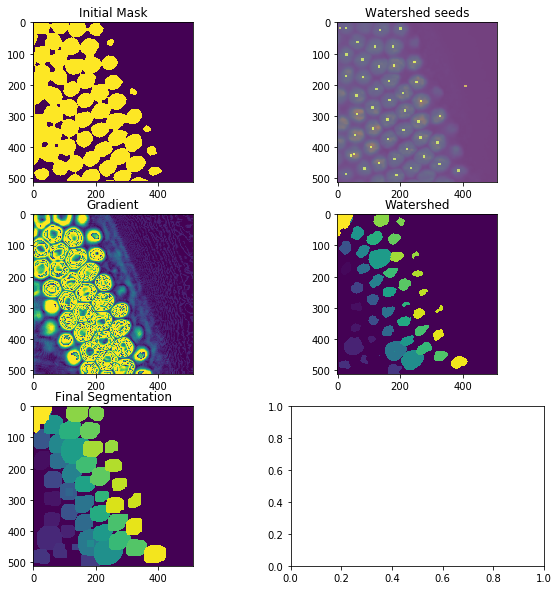

In [4]:
z_sep = 70
xy_sep = 70
nuc = imp.segment_nuclei3D_5(bgsub[1,0], seed_window=(z_sep,xy_sep,xy_sep), size_min=0, dilation_length = 20, circularity_min=0.5, display=True)

It occurred to me that the smarter way to do that step would be instead of a blind morphological dilation, do a smart expansion of nuclei, using the signal to determine where to expand the mask. 

One idea:
* Define means for background and foreground from mask.
* Draw a box around the nucleus using the extents in each direction (using supplied dimensions for box size).
* Within that box, apply some threshold based on background/foreground values, add the pixels that cross threshold to the nucleus.
* Call it smart_dilate.

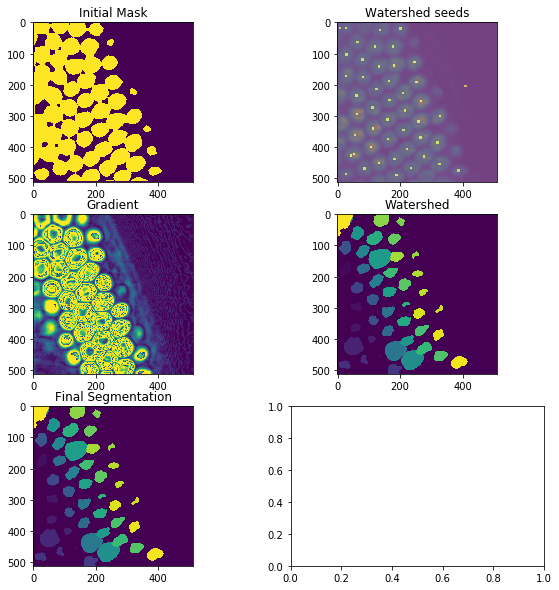

In [30]:
nuc = imp.segment_nuclei3D_5(bgsub[1,0], seed_window=(z_sep,xy_sep,xy_sep), size_min=0, dilation_length = 1, circularity_min=0.5, display=True)

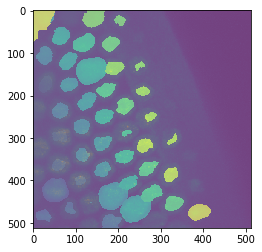

In [7]:
plt.imshow(stack[1,0].max(axis=0), alpha=0.5)
plt.imshow(nuc.max(axis=0), alpha=0.5)

In [20]:
test = ndi.filters.gaussian_filter(stack[1,0],3)

In [48]:
reload(imp)
from imagep import labelmask_apply_morphology

def smart_dilate(im, labelmask, dilation_length):
    bg_mean = np.mean(im[labelmask == 0])
    fg_mean = np.mean(im[labelmask > 0])
    mult= 0.5
    t = bg_mean + ((fg_mean - bg_mean) * mult)
    #labelmask_threshed = np.copy(labelmask)
    #labelmask_threshed[]
    # Make a new labelmask, dilate it, threshold, for each nuc in old mask, add pixels that are now that nuc in dilated mask
    labelmask_dilated = labelmask_apply_morphology(labelmask, 
            mfunc=ndi.morphology.binary_dilation, 
            struct=np.ones((1, dilation_length, dilation_length)), 
            expand_size=(1, dilation_length + 1, dilation_length + 1))
    # Remove any pixels from dilated mask that are below thresh
    labelmask_dilated[im < t] = 0
    for n in np.unique(labelmask):
        # Pixels matching nuc in dilated mask added to old mask, pixels in old mask that are n
        # and 0 in dilated mask are kept at n. So dilation doesn't remove any nuclear pixels.
        labelmask[labelmask_dilated == n] = n
        #pass
    
    
    for n in np.unique(labelmask)[1:]:
        z,i,j = np.where(labelmask == n)
# 2 - dilate 20, thresh 0.7
# 3 - dilate, no thresh        
nuc_cp3 = np.copy(nuc)    
testout=smart_dilate(test,nuc_cp3, 20)

#plt.imshow(test.max(axis=0), alpha=0.5)
#plt.imshow(nuc_cp.max(axis=0), alpha=0.3)

In [49]:
viewer([test/30,nuc_cp2, nuc_cp3],'zxy')

interactive(children=(Dropdown(description='Color', index=4, options=('Greens', 'magma', 'gray', 'cividis', 'v…

Added smart dilation to the __segment_nuclei3D_5__ in imagep.py. Testing:

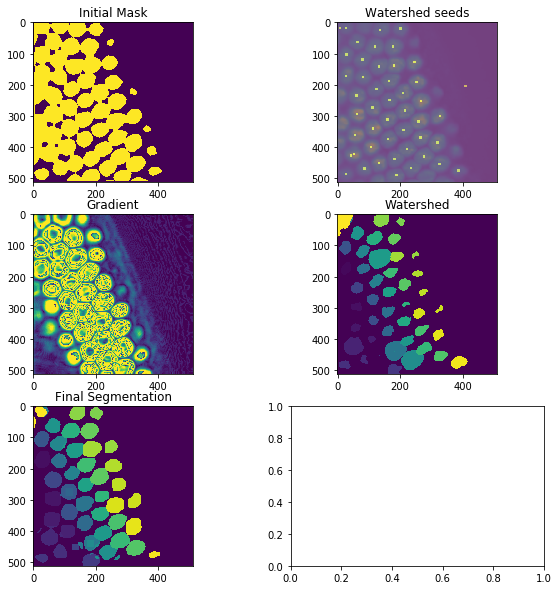

In [55]:
reload(imp)
a1 = imp.segment_nuclei3D_5(bgsub[1,0], seed_window=(z_sep,xy_sep,xy_sep), size_min=0, sensitivity=0.7,dilation_length = 20, circularity_min=0.5, display=True)

In [56]:
viewer([nuc_cp2, a1,a],'zxy')

interactive(children=(Dropdown(description='Color', index=4, options=('Greens', 'magma', 'gray', 'cividis', 'v…

OK I updated it. Pushed to gitub. Will move on now.